In [1]:
!pip install unidecode

import pickle
import numpy as np
import matplotlib.pyplot as plt

from torch import optim, nn
from modules.dataset import *
from modules.network import *
from modules.embeddings import *
from modules.generate_text import *
from torch import save, device, cuda
from torch.utils.data import DataLoader

In [2]:
device = device("cuda") if cuda.is_available() else device("cpu")
print('Selected device:', device)

Selected device: cuda


In [3]:
# Colab packages
from google.colab import files, drive

# Connect drive to colab
drive.mount('/content/drive')

# Create directories (Colab)
!mkdir ./drive/My\ Drive/Colab\ Notebooks/images
!mkdir ./drive/My\ Drive/Colab\ Notebooks/results
!mkdir ./drive/My\ Drive/Colab\ Notebooks/results/losses

# Set paths
images_path = "./drive/My Drive/Colab Notebooks/images"
res_path = "./drive/My Drive/Colab Notebooks/results/losses"

# Set local paths
# images_path = "./images"
# res_path = "./data/losses"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘./drive/My Drive/Colab Notebooks/images’: File exists
mkdir: cannot create directory ‘./drive/My Drive/Colab Notebooks/results’: File exists
mkdir: cannot create directory ‘./drive/My Drive/Colab Notebooks/results/losses’: File exists


# Dataset

## Loading and preprocessing

In [4]:
#%%Loading the dataset 

min_len = 18
dataset = Bible('./data/bible.txt', min_len = min_len)

    
len(dataset)

21374

In [5]:
# Check if every sentence begins with two ":"
i, j = 0, 0
for sentence in dataset:
    if sentence[0] == ':' and  sentence[1] == ':':
        i += 1
    elif sentence[0] == ':' and  sentence[1] != ':':
        j += 1

In [6]:
i

0

In [7]:
j

0

Mean sentence length: 31.432675212875456
Max sentence length: 102
Min sentence length: 18


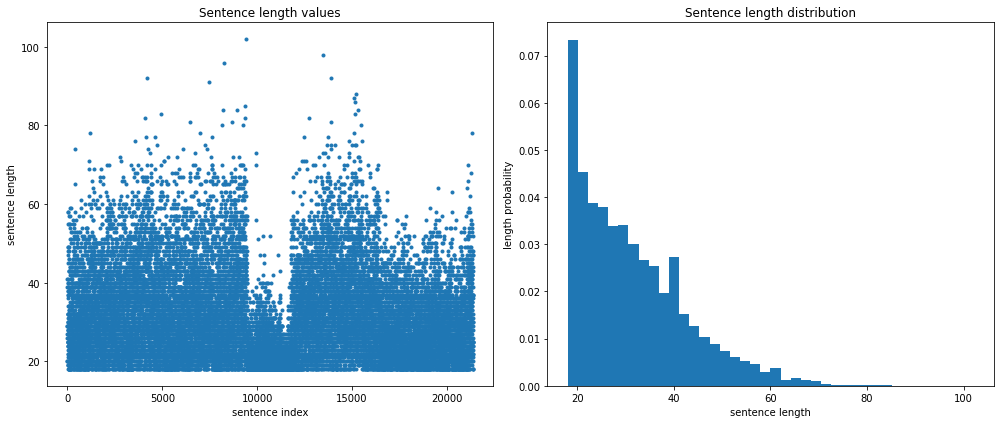

In [8]:
# Dataset visualization
lengths = [ len(sentence)  for sentence in dataset ]
fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs.ravel()
axs[0].set_title('Sentence length values')
axs[0].set_xlabel('sentence index')
axs[0].set_ylabel('sentence length')
_ = axs[0].plot(lengths, '.')
axs[1].set_title('Sentence length distribution')
axs[1].set_xlabel('sentence length')
axs[1].set_ylabel('length probability')
_ = axs[1].hist(lengths, bins=40, density=True)

print('Mean sentence length:', np.mean(lengths))
print('Max sentence length:', np.max(lengths))
print('Min sentence length:', np.min(lengths))

plt.tight_layout()
plt.savefig(images_path+f'/bible_{min_len}.png')
plt.show()

In [9]:
print(len(set(dataset.words)))

10775


## Word embeddings

In [10]:
# Define the embedding dimension
embedding_dim = 50

# Copy dataset words
words = set(dataset.words.copy())

In [ ]:
%%time 

# Load embeddings from glove
glove = from_file(path='data/glove.6B.50d.txt',
                  words=words
                 )

In [ ]:
# Analyse glove embeddings
print('Mean:', np.mean(list(glove.values())), ', STD: ', np.std(list(glove.values())) )

In [ ]:
# Define embeddings for unknown words by sampling from normal distirbution, using found parameters
mean = np.mean(list(glove.values()))
std = np.std(list(glove.values())) 

# Initialize randomly sampled embeddings
embeddings = gaussian_sampling(mean, std, dim=embedding_dim, words=words)
# Loop through each embedded word
for word, vector in embeddings.items():
    # Subsititute current entry with glove one, if available
    embeddings[word] = glove.get(word, vector)

# Get list of words
words = [*embeddings.keys()]
# Get vectors as float tensor
vectors = torch.tensor([*embeddings.values()], dtype=torch.float)

In [ ]:
vectors.shape

In [ ]:
# Analyse generated embeddings
print('Mean:', np.mean(list(embeddings.values())), ', STD: ', np.std(list(embeddings.values())) )

In [ ]:
a = vectors.shape[0] # obtained with all words in vocab and in glove + words in vocab not in glove
b = len(set(glove.keys()) & set(dataset.words)) + len(set(dataset.words) - set(glove.keys())) 
# sanity check
a == b

In [ ]:
with open('./data/embeddings_bible', 'wb') as f:
    pickle.dump(embeddings, f, pickle.HIGHEST_PROTOCOL)

In [11]:
# Load embeddings
with open('./data/embeddings_bible', 'rb') as f:
    embeddings = pickle.load(f)

# Get list of words
words = [*embeddings.keys()]
# Get vectors as float tensor
vectors = torch.tensor([*embeddings.values()], dtype=torch.float)

In [12]:
crop_len = 15

# Define transformation 
dataset.transform = transforms.Compose([
    RandomCrop(crop_len),
    WordToIndex(words),
    ToTensor()
])

In [13]:
# Defined the transform, this call returns the word index (after random cropping)
dataset[0].shape

torch.Size([15])

# RNN

In [14]:
classification = True

params = {
        # network
        'hidden_units' : 2**9, # symmetric layers
        'layers_num' : 2,
        'dropout_prob' : 0.3,
        'architecture' : 'GRU',

        # training
        'batch_size' : 1000,
        'num_epochs' : 200,

        # optimizer
        'lr' : 1e-3,
        'wd' : 1e-4,
    
        # dataset
        'crop_len' : crop_len,
        'min_len' : min_len
        }

# save
out_dir = '{}_{}_{}_{}_{}_{}'.format(params['architecture'], 
                                     params['crop_len'], 
                                     params['min_len'], 
                                     params['batch_size'], 
                                     params['lr'], 
                                     params['wd'])

In [15]:
# Split initial dataset in train dataset and test dataset
train_dataset, test_dataset = split_train_test(dataset, 0.9)
# Make train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
# Make test dataloader
test_dataloader = DataLoader(test_dataset, shuffle=False)

In [16]:
#TODO: hyperparameter optimization, this part must be included in the GridSearch iteration

#%% Initialize network
net = Network(vocab_size = vectors.shape[0],
              embedding_dim = embedding_dim,
              hidden_units = params['hidden_units'],
              layers_num = params['layers_num'],
              hidden_type = params['architecture'],
              trained_embeddings = vectors,
              freeze_embeddings = False,
              dropout_prob = params['dropout_prob']
             )

# Define optimizer
optimizer = optim.Adam(net.parameters(), lr=params['lr'], weight_decay=params['wd'])
# Define loss function
# regression case
loss_fn = nn.MSELoss()
# classification case
cl = ''
if classification == True:
    loss_fn = nn.CrossEntropyLoss()
    cl = '_class'

net.to(device)

Network(
  (rnn): GRU(50, 512, num_layers=2, batch_first=True, dropout=0.3)
  (out): Linear(in_features=512, out_features=11540, bias=True)
  (embed): Embedding(11540, 50)
)

In [17]:
%%time

use_checkpoint = False

# Initialize WordToVector
w2i = WordToIndex(words)

# Define losses containers
train_loss_epochs = []
val_loss_epochs = []


# Load checkpoint
if use_checkpoint:
    # Load hyperparameters
    with open(res_path + "/" + out_dir + '_bible' + cl, 'rb') as f:
          losses = pickle.load(f)
    start = losses['epochs'] + 1
    train_loss_epochs = losses['train']
    val_loss_epochs = losses['val']

    # Load model
    state = torch.load(res_path + "/state_" + out_dir + '_bible' + cl + '.pth', map_location = device)

    # Load weights
    net.load_state_dict(state)
    net.to(device)
    # Load optimizer
    opt = torch.load(res_path + "/opt_" + out_dir + '_bible' + cl + '.pth', map_location = device)
    optimizer.load_state_dict(opt)

#%% Train network   
for epoch in range(start, params['num_epochs']):

    print('\n\n EPOCH %d/%d' % (epoch + 1, params['num_epochs']))
    
    # Set training mode
    net.train()
    # Define losses container for one epoch
    train_loss_log = []
    
    # Iterate batches
    for batch_sample in train_dataloader:
        # Extract batch
        batch = batch_sample.long().to(device)
        # Update network
        batch_loss = net.train_batch(batch, loss_fn, optimizer)
        train_loss_log.append(batch_loss)
        # print('\t Training loss (single batch):', batch_loss)
        
    print('\t Training loss (epoch - mean): ', np.mean(train_loss_log) )
    train_loss_epochs.append(np.mean(train_loss_log))
    
    # Set evaluation mode
    net.eval()
    val_loss_log = []
    with torch.no_grad():
        for batch_sample in test_dataloader:
            batch = batch_sample.long().to(device)
            val_loss = net.test_batch(batch, loss_fn)
            val_loss_log.append(val_loss)
            
        print('\t Validation loss (epoch - mean):', np.mean(val_loss_log))
        val_loss_epochs.append(np.mean(val_loss_log))
        
        if (epoch + 1) % 10 == 0:
            if not classification:
                # Embedding matrix - updated
                X = net.embed.weight.detach().numpy()
            # Set seed
            seed = 'I want you to know that'
            # Generate sample text
            print('\n--- Sample text ---\n')
            _ = generate_text(net, seed, 5, device, words, w2i)
            print('\n\n-------------------\n')
        
    # Early stopping
    # if epoch>200 and abs(val_loss_epochs[-1] - val_loss_epochs[-200]) < 1e-10:
    #    break

    losses = { 'train': train_loss_epochs, 'val':  val_loss_epochs, 'params' : params , 'epochs': epoch}

    # Save losses dictionary
    with open(res_path + "/" + out_dir + '_bible', 'wb') as f:
        pickle.dump(losses, f, pickle.HIGHEST_PROTOCOL)
        
    # Save model 
    torch.save(net.state_dict(), res_path + "/state_" + out_dir + '_bible_class.pth')
    # Save optimizer
    torch.save(optimizer.state_dict(), res_path + "/opt_" + out_dir + '_bible_class.pth')



 EPOCH 1/200


RuntimeError: ignored

In [ ]:
# Plot losses
plt.close('all')
plt.figure(figsize=(12,8))

plt.semilogy(train_loss_epochs, label='Train loss')
plt.semilogy(val_loss_epochs, label='Validation loss', linestyle='dashed')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig(images_path+f"/model_losses_"  + out_dir + "_bible" + cl + ".png")
plt.show()

# Text generation

In [ ]:
# Set seed
seed = 'In the name of God we say'

In [ ]:
# Load embeddings
with open('./data/embeddings_bible', 'rb') as f:
    embeddings = pickle.load(f)
# Get list of words
words = [*embeddings.keys()]
# Get vectors as float tensor
vectors = torch.tensor([*embeddings.values()], dtype=torch.float)

# Load hyperparameters
with open(res_path + "/" + out_dir + '_bible' + cl, 'rb') as f:
    params = pickle.load(f)
    params = params['params']
    
# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load model
state = torch.load(res_path + "/state_" + out_dir + '_bible' + cl + '.pth', map_location = device)

net = Network(vocab_size = len(embeddings.keys()),
              embedding_dim = 50,
              hidden_units = params['hidden_units'],
              layers_num = params['layers_num'],
              hidden_type = params['architecture'],
              trained_embeddings = vectors,
              dropout_prob = params['dropout_prob']
             )

net.load_state_dict(state)

# Embedding matrix
X = net.embed.weight.detach().numpy()

net.to(device)

In [ ]:
# Initialize WordToVector
w2i = WordToIndex(words)

In [ ]:
_ = generate_text(net, seed, 15, device, words, w2i)